# Make_cfos_cell_df
In this notebook I make the cell count dataframe for Chris Zimmerman's zimmerman_01/zimmerman_01-001 c-fos SmartSPIM data. 

## Requirements:
- pip install brain-atlas-toolkit

In [1]:
import os, glob
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from concurrent.futures import ProcessPoolExecutor
import pickle
from brain_atlas_toolkit import graph_tools
%matplotlib inline

In [3]:
# use the 16 bit eroded Princeton Mouse Atlas file
eroded_atlas_file = '/jukebox/LightSheetTransfer/atlas/annotation_sagittal_atlas_20um_16bit_hierarch_labels_60um_edge_80um_vent_erosion.tif'
eroded_atlas_vol = np.array(tifffile.imread(eroded_atlas_file)).astype('uint16')

In [4]:
# Get all of the ids for the regions in the atlas volume 
atlas_segments = np.unique(eroded_atlas_vol)
atlas_segments = np.array([x for x in atlas_segments if x!=0]) # take out the 0 segment since it is not a brain region

In [5]:
# Segment properties file for this atlas hierachy -> This contains the mapping between id and region name
segment_props_file = '/jukebox/wang/ahoag/lightsheet_helper_scripts/projects/combine_cfos_batches/data/pma_segment_properties_info'

In [6]:
# Load in ontology json file to python dictionary
ontology_json_file = "../data/PMA_ontology.json"
with open(ontology_json_file,'r') as infile:
    ontology_dict = json.load(infile)

In [7]:
# Path to transformed cells file -> Here is where you would filter by size but we need to figure out
# How to keep size in the file while applying the transformation to registered space
cells_transformed_file = os.path.join('/jukebox/wang/ahoag/test_clearmap2/output',
                         'cz15/zimmerman_01_smartspim/zimmerman_01-001',
                         'imaging_request_1/output','cells_transformed_to_atlas.npy')

In [8]:
converted_points = np.load(cells_transformed_file)

In [9]:
converted_points

array([( -9, 413, 328), (  5,  20, 185), (  0, 310, 241), ...,
       (372, 214, 148), (372, 216, 149), (374, 533, 230)],
      dtype=[('x', '<i8'), ('y', '<i8'), ('z', '<i8')])

In [10]:
# This cell takes ~10 seconds

# Rearrange the points array 
xyz = np.asarray([(int(xx[0]), int(xx[1]), int(xx[2])) for xx in converted_points]) #cells are counted in horizontal volumes

# initialize empty volume with the same dimensions as the atlas
cell_map = np.zeros(eroded_atlas_vol.shape).astype('uint8')
# read the cells into a volume -- voxels that have a cell get a 1, otherwise 0
for x,y,z in xyz:
    try:
        cell_map[z,y,x] = 1 # no dilation
    except Exception as e:
        # Some cells will fall outside the volume - just how clearmap works
        pass
# for atlas_segment in atlas_segments:
#     atlas_mask = eroded_atlas_vol == atlas_segment
#     count = sum(cell_map[atlas_mask])
#     count_dict[atlas_segment] = count
# return count_dict


In [11]:
cell_map.shape

(540, 640, 352)

In [12]:
eroded_atlas_vol.shape

(540, 640, 352)

Those two shapes should be the same

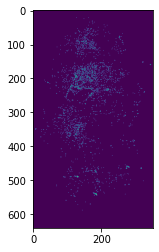

Can see some cells, but hard to make out outline

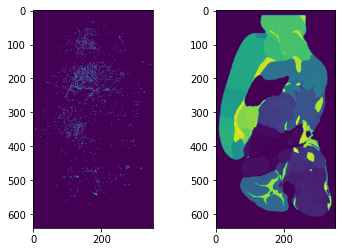

In [17]:
# Plot the same slice through the cell volume and the atlas annotation volume
fig = plt.figure()
ax_cells=fig.add_subplot(121)
ax_atlas=fig.add_subplot(122)
ax_cells.imshow(cell_map[200])
ax_atlas.imshow(eroded_atlas_vol[200])

This is just showing cells in sagittal plane 200, but shows that they are indeed aligned. Let's check horizontal planes as those might be more obvious

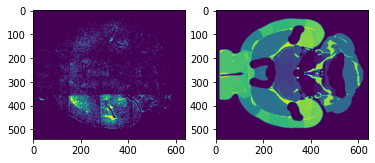

In [18]:
fig = plt.figure()
ax_cells=fig.add_subplot(121)
ax_atlas=fig.add_subplot(122)
ax_cells.imshow(cell_map[:,:,200])
ax_atlas.imshow(eroded_atlas_vol[:,:,200])

Much easier to see alignment now. Can see some tiling in the cell distribution. May want to try making a better flat file and reapply pystripe.

In [19]:
# write a function to get counts in brain region so I can parallelize it
def get_count(segment_list):
    """ Given a list of segment ids,
    populate a dictionary mapping id:count
    for each segment id"""
    print("this core received segment list:",segment_list)
    print()
    this_count_dict = {}
    for segment in segment_list:
        atlas_mask = eroded_atlas_vol == segment
        count = sum(cell_map[atlas_mask])
        this_count_dict[segment] = count
    return this_count_dict

In [20]:
%%time 
# This cell took ~7 seconds with 24 cores on scotty
# Make a dictionary that maps region id to the cell count in that region
master_count_dict = {}
chunk_size = 10 # Each core runs get_count() on this many different regions
chunked_segment_lists = [atlas_segments[i:i+chunk_size] for i in range(0,len(atlas_segments),chunk_size)]
with ProcessPoolExecutor(max_workers=24) as executor:
    for count_dict_i in executor.map(get_count,chunked_segment_lists):
        try:
            for key in count_dict_i:
                master_count_dict[key] = count_dict_i[key]
        except Exception as exc:
            print(f'generated an exception: {exc}')

this core received segment list:this core received segment list:this core received segment list:this core received segment list:this core received segment list: this core received segment list:this core received segment list: this core received segment list:this core received segment list:this core received segment list:this core received segment list:this core received segment list: this core received segment list:  this core received segment list: this core received segment list: this core received segment list:this core received segment list: [ 1  4  6  7  8  9 10 11 15 16]  [17 19 20 21 23 24 25 26 28 29] this core received segment list:  this core received segment list: [109 110 111 112 113 114 115 116 117 118][ 94  96  97  98  99 101 102 104 106 107] [30 31 32 33 34 35 36 38 40 41][136 143 144 147 148 155 156 158 159 160]  
[58 59 60 61 62 65 66 75 76 77]
[78 79 81 84 85 87 88 89 92 93] [42 43 47 50 51 52 53 54 56 57] [121 122 124 125 129 130 131 133 134 135][253 254 257 258 261 

In [21]:
# Take a look at the count dictionary
master_count_dict

{1: 2,
 4: 41344,
 6: 174,
 7: 123,
 8: 654,
 9: 685,
 10: 47,
 11: 17471,
 15: 1363,
 16: 24,
 17: 544,
 19: 11581,
 20: 1,
 21: 2,
 23: 9387,
 24: 6166,
 25: 2256,
 26: 2154,
 28: 5029,
 29: 1309,
 30: 78,
 31: 36658,
 32: 134,
 33: 112,
 34: 149,
 35: 252,
 36: 167,
 38: 6104,
 40: 1407,
 41: 730,
 42: 172,
 43: 1613,
 47: 167,
 50: 141,
 51: 5056,
 52: 2077,
 53: 6131,
 54: 57,
 56: 584,
 57: 1390,
 58: 1133,
 59: 30,
 60: 830,
 61: 104,
 62: 20,
 65: 476,
 66: 799,
 75: 391,
 76: 288,
 77: 149,
 78: 441,
 79: 943,
 81: 3674,
 84: 0,
 85: 0,
 87: 0,
 88: 1,
 89: 396,
 92: 70,
 93: 0,
 94: 9,
 96: 4,
 97: 1,
 98: 0,
 99: 80,
 101: 0,
 102: 0,
 104: 0,
 106: 136,
 107: 49,
 109: 2687,
 110: 939,
 111: 253,
 112: 473,
 113: 71,
 114: 0,
 115: 76,
 116: 2,
 117: 761,
 118: 0,
 121: 585,
 122: 6,
 124: 504,
 125: 3,
 129: 57,
 130: 0,
 131: 1,
 133: 0,
 134: 460,
 135: 1096,
 136: 806,
 143: 1011,
 144: 1279,
 147: 7,
 148: 160,
 155: 1,
 156: 0,
 158: 0,
 159: 108,
 160: 7820,
 162: 25

In [23]:
len(master_count_dict)

610

In [24]:
len(atlas_segments)

610

In [22]:
# There should be the same number of entries in master_count_dict as there are segment ids

Now convert IDs to names using the segment properties file

In [23]:
with open(segment_props_file,'r') as infile:
    segment_props_dict = json.load(infile)

In [24]:
# Load ids and names and then show the names
ids = segment_props_dict['inline']['ids']
segment_names = segment_props_dict['inline']['properties'][0]['values']
segment_names

['None: root',
 'grey: Basic cell groups and regions',
 'BS: Brain stem',
 'MB: Midbrain',
 'MBmot: Midbrain, motor related',
 'III: Oculomotor nucleus',
 'MT: Medial terminal nucleus of the accessory optic tract',
 'LT: Lateral terminal nucleus of the accessory optic tract',
 'DT: Dorsal terminal nucleus of the accessory optic tract',
 'IV: Trochlear nucleus',
 'MRN: Midbrain reticular nucleus',
 'MRNm: Midbrain reticular nucleus, magnocellular part',
 'MRNmg: Midbrain reticular nucleus, magnocellular part, general',
 'MRNp: Midbrain reticular nucleus, parvicellular part',
 'RN: Red nucleus',
 'AT: Anterior tegmental nucleus',
 'RR: Midbrain reticular nucleus, retrorubral area',
 'SCm: Superior colliculus, motor related',
 'SCig: Superior colliculus, motor related, intermediate gray layer',
 'SCig-a: Superior colliculus, motor related, intermediate gray layer, sublayer a',
 'SCig-b: Superior colliculus, motor related, intermediate gray layer, sublayer b',
 'SCig-c: Superior colliculus

In [25]:
# Create a dictionary mapping the ids to the names, and strip off the acroynms for the time being
segment_name_dict = {int(ids[ii]):segment_names[ii].split(':')[1].strip() for ii in range(len(ids))}

In [26]:
segment_name_dict

{1: 'root',
 2: 'Basic cell groups and regions',
 3: 'Brain stem',
 4: 'Midbrain',
 5: 'Midbrain, motor related',
 6: 'Oculomotor nucleus',
 7: 'Medial terminal nucleus of the accessory optic tract',
 8: 'Lateral terminal nucleus of the accessory optic tract',
 9: 'Dorsal terminal nucleus of the accessory optic tract',
 10: 'Trochlear nucleus',
 11: 'Midbrain reticular nucleus',
 12: 'Midbrain reticular nucleus, magnocellular part',
 13: 'Midbrain reticular nucleus, magnocellular part, general',
 14: 'Midbrain reticular nucleus, parvicellular part',
 15: 'Red nucleus',
 16: 'Anterior tegmental nucleus',
 17: 'Midbrain reticular nucleus, retrorubral area',
 18: 'Superior colliculus, motor related',
 19: 'Superior colliculus, motor related, intermediate gray layer',
 20: 'Superior colliculus, motor related, intermediate gray layer, sublayer a',
 21: 'Superior colliculus, motor related, intermediate gray layer, sublayer b',
 22: 'Superior colliculus, motor related, intermediate gray layer

In [27]:
# Finally, create the dictionary that maps region name to the cell count in that region
count_dict_names = {}
for atlas_segment_id in atlas_segments:
    segment_name = segment_name_dict[atlas_segment_id]
    count_dict_names[segment_name] = master_count_dict[atlas_segment_id]

In [28]:
count_dict_names

{'root': 2,
 'Midbrain': 41344,
 'Oculomotor nucleus': 174,
 'Medial terminal nucleus of the accessory optic tract': 123,
 'Lateral terminal nucleus of the accessory optic tract': 654,
 'Dorsal terminal nucleus of the accessory optic tract': 685,
 'Trochlear nucleus': 47,
 'Midbrain reticular nucleus': 17471,
 'Red nucleus': 1363,
 'Anterior tegmental nucleus': 24,
 'Midbrain reticular nucleus, retrorubral area': 544,
 'Superior colliculus, motor related, intermediate gray layer': 11581,
 'Superior colliculus, motor related, intermediate gray layer, sublayer a': 1,
 'Superior colliculus, motor related, intermediate gray layer, sublayer b': 2,
 'Superior colliculus, motor related, intermediate white layer': 9387,
 'Superior colliculus, motor related, deep gray layer': 6166,
 'Superior colliculus, motor related, deep white layer': 2256,
 'Substantia nigra, reticular part': 2154,
 'Cuneiform nucleus': 5029,
 'Ventral tegmental area': 1309,
 'Ventral tegmental nucleus': 78,
 'Periaqueducta

We're actually not quite done yet. What we have counted is the cells in each segment of the brain atlas annotation volume. It turns out that big regions like "Thalamus" do not take up the whole volume of the Thalamus in the atlas, but rather they occupy a shell around the outside of the real Thalamus. This is done so that you can have subregions of the Thalamus that occupy part of the inner volume, like the thalamic nuclei. This is done for visualization purposes only. Here is a demonstration showing this problem: 

In [29]:
# First let's find the ID in the annotation volume corresponding to Thalamus
[(k,v) for (k,v) in segment_name_dict.items() if v=='Thalamus']

[(213, 'Thalamus')]

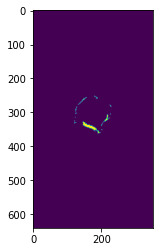

In [30]:
# So Thalamus has ID 213. Let's look at the part of that annotation volume where the value is 213
# Make a new volume the same shape as the annotation volume so we can apply a mask to show just that region
thal_vol = np.zeros_like(eroded_atlas_vol)
thal_mask = eroded_atlas_vol == 213
thal_vol[thal_mask] = 213
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(thal_vol[200,:,:])

The bright portion of the above image is the region that the annotation volume calls the Thalamus. As you can see this is just a shell of voxels. So in our count dictionary the counts listed for the Thalamus are only the cells that fall within this small shell. That's obviously not what we want. To get the counts in the entire thalamus, we need to know what are the IDs of the subregions of the thalamus so we can add the counts in those inner regions to the counts in this shell. To do this, we make use of the brain_atlas_toolkit python package: https://github.com/BrainCOGS/brain_atlas_toolkit

In [31]:
# Make the ontology graph
ontology_graph = graph_tools.Graph(ontology_dict)

In [33]:
# For example print out all subregions of the Thalamus 
ontology_graph.get_progeny('Thalamus')

['Thalamus, polymodal association cortex related',
 'Intralaminar nuclei of the dorsal thalamus',
 'Rhomboid nucleus',
 'Central lateral nucleus of the thalamus',
 'Central medial nucleus of the thalamus',
 'Paracentral nucleus',
 'Parafascicular nucleus',
 'Posterior intralaminar thalamic nucleus',
 'Lateral group of the dorsal thalamus',
 'Lateral posterior nucleus of the thalamus',
 'Suprageniculate nucleus',
 'Posterior complex of the thalamus',
 'Posterior limiting nucleus of the thalamus',
 'Ethmoid nucleus of the thalamus',
 'Retroethmoid nucleus',
 'Anterior group of the dorsal thalamus',
 'Anterodorsal nucleus',
 'Anteromedial nucleus',
 'Anteromedial nucleus, dorsal part',
 'Anteromedial nucleus, ventral part',
 'Lateral dorsal nucleus of thalamus',
 'Anteroventral nucleus of thalamus',
 'Interanterodorsal nucleus of the thalamus',
 'Interanteromedial nucleus of the thalamus',
 'Reticular nucleus of the thalamus',
 'Medial group of the dorsal thalamus',
 'Intermediodorsal nuc

In [34]:
# Using these progeny names get their IDs and show visually that these fill out the shell
# Takes 5-10 seconds
thalamus_progeny = ontology_graph.get_progeny('Thalamus')
thalamus_progeny_ids = [key for key in segment_name_dict if segment_name_dict[key] in thalamus_progeny]
# Add these to the masked volume above
for ID in thalamus_progeny_ids:
    if ID in master_count_dict:
        ID_mask = eroded_atlas_vol==ID
        thal_vol[ID_mask] = ID

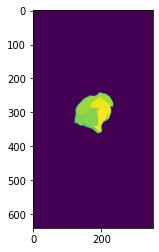

In [35]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(thal_vol[200,:,:])

We can now see that the whole Thalamus is filled out, verifying that we found all of the descendents. To be thorough let's look at a few other slices through the volume.

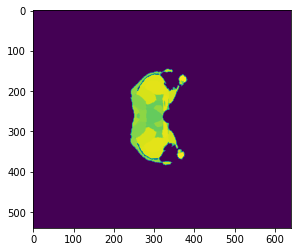

In [36]:
# Horizontal slice
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(thal_vol[:,:,200])

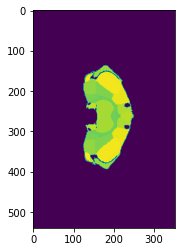

In [37]:
# Coronal slice
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(thal_vol[:,300,:])

Looks good. Now we can fix the cell counts to include these inner regions of the shell

In [38]:
# Use names to get counts in those regions and add them to the shell to get total Thalamus cell count
thalamus_progeny = ontology_graph.get_progeny('Thalamus')
thalamus_count = count_dict_names['Thalamus'] # Initialized to the shell count
# Now loop over progeny ids and add to the count
print(f"Thalamus shell has {thalamus_count} cells")
for prog in thalamus_progeny:
    # Note that not all subregions are in the atlas volume, so skip the ones that aren't
    if prog not in count_dict_names.keys():
        continue
    thalamus_count +=count_dict_names[prog]
print(f"Final count in entire Thalamus is {thalamus_count} cells") 

Thalamus shell has 15092 cells
Final count in entire Thalamus is 187313 cells


We need to do this for all regions in the count dictionary (not just thalamus) since all regions have the same shell problem, unless they have no progeny in which case they have the correct counts already. Fortunately this step is very fast.

In [39]:
corrected_count_dict = {}
for region in count_dict_names.keys():
    # initialize with the shell count
    counts_region = count_dict_names[region]
    progeny = ontology_graph.get_progeny(region)
    if progeny != []:
        for prog in progeny:
            # Note that not all subregions are in the atlas volume, so skip the ones that aren't
            try:
                counts_region += count_dict_names[prog]
            except KeyError:
                continue
    corrected_count_dict[region] = counts_region

In [40]:
# Finally, we can make our pandas dataframe that has the correct counts in each brain region listed in the atlas
df = pd.DataFrame([corrected_count_dict])
df

,root,Midbrain,Oculomotor nucleus,Medial terminal nucleus of the accessory optic tract,Lateral terminal nucleus of the accessory optic tract,Dorsal terminal nucleus of the accessory optic tract,Trochlear nucleus,Midbrain reticular nucleus,Red nucleus,Anterior tegmental nucleus,...,supraoptic commissures,fasciculus retroflexus,habenular commissure,stria medullaris,nigrostriatal tract,rubrospinal tract,ventral tegmental decussation,crossed tectospinal pathway,direct tectospinal pathway,doral tegmental decussation
0,2934980,169097,174,123,654,685,47,17471,1363,24,...,109,153,28,445,337,1240,390,349,0,13


In [41]:
# Can save the file as a CSV using the following syntax
savename = 'zimmerman_01-001_smartspim_clearmap_results_allregions_corrected_counts.csv'
df.to_csv(savename,index=False) # index=False will not save the "0" at the very beginning of the row 